# Replication of NetSurfP 2.0 with pyTorch

The purpose of this notebook is to replicate the current version of NetSurfP 2.0

**Load libraries**

The different libraries are initialized and pytorch is either configured to use the CPU or an available GPU.

In [1]:
import pylab
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

# debugging
import pdb

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 1. Preparation of the data

Each dataset is compressed as a numpy zip and the dimensions of the dataset are as following: 

**[sequence, position, label]**

The labels are as following in the data (shown by index):
- [0:20] Amino Acids (sparse encoding) (Unknown residues are stored as an all-zero vector)
- [20:50] hmm profile
- [50] Seq mask (1 = seq, 0 = empty)
- [51] Disordered mask (0 = disordered, 1 = ordered)
- [52] Evaluation mask (For CB513 dataset, 1 = eval, 0 = ignore)
- [53] ASA (isolated)
- [54] ASA (complexed)
- [55] RSA (isolated)
- [56] RSA (complexed)
- [57:65] Q8 GHIBESTC (Q8 -> Q3: HHHEECCC)
- [65:67] Phi+Psi
- [67] ASA_max

### Loading the datasets

In [2]:
train_hhblits = np.load("../data/nsp2/training_data/Train_HHblits.npz")
CB513_hhblits = np.load("../data/nsp2/training_data/CB513_HHblits.npz")
TS115_hhblits = np.load("../data/nsp2/training_data/TS115_HHblits.npz")
CASP12_hhblits = np.load("../data/nsp2/training_data/CASP12_HHblits.npz")

train_mmseqs = np.load("../data/nsp2/training_data/Train_MMseqs.npz")
CB513_mmseqs = np.load("../data/nsp2/training_data/CB513_MMseqs.npz")
TS115_mmseqs = np.load("../data/nsp2/training_data/TS115_MMseqs.npz")
CASP12_mmseqs = np.load("../data/nsp2/training_data/CASP12_MMseqs.npz")

### Custom Data loader class

A data loader class is created to load the NSP data into a DataLoader object. The DataLoader is a pytorch object, thats used to feed the data as batches. Which will be usefull when training and evaluating the NSP model. The NSPData class divides the dataset into input data and target labels.

In [3]:
class NSPData(Dataset):
    def __init__(self, dataset):
        """ Constructor
        Args:
            X (np.array): The array that contains the training data
            y (np.array): The array that contains the test data
        """
        self.data = torch.tensor(dataset['data'][:, :, :50]).float()
        self.targets = torch.tensor(dataset['data'][:, :, 50:68]).float()

    def __getitem__(self, index):
        """ Returns train and test data at an index
        Args:
            index (int): Index at the array
        """
        return self.data[index], self.targets[index]
    
    def __len__(self):
        """Returns the length of the data"""
        return len(self.data)

It is important to have a training and validation set when training to evaluate the training performance. Therefore, a function that splits the dataset into training and evaluation is created for that purpose.

In [4]:
def split_dataset(batch_size, dataset, validation_fraction = 0.20):
    """ Splits the dataset into train and validation
    Args:
        batch_size (int): size of each batch
        dataset (np.array): dataset containing training data
        validation_fraction (float): the size of the validation set as a fraction
    """
        
    num_train = len(dataset['data'])
    indices = list(range(num_train))
    split = int(np.floor(validation_fraction * num_train))
    
    # subset the dataset
    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    training_set = DataLoader(NSPData(dataset), sampler=train_sampler, batch_size=batch_size)
    validation_set = DataLoader(NSPData(dataset), sampler=valid_sampler, batch_size=batch_size)
    
    return training_set, validation_set
    

**Instanciate data into the data loader class**

The training datasets are splitted into training and validation for training. Whereas the test sets are simply loaded, since they are independent datasets. The batch sizes is set to 15. The default training/validation split is 80/20.

In [5]:
batch_size = 15

In [6]:
# training and validation sets
train_hhblits = split_dataset(batch_size, train_hhblits)
train_mmseqs = split_dataset(batch_size, train_mmseqs)

# test sets
CB513_hhblits = DataLoader(NSPData(CB513_hhblits), batch_size=batch_size)
TS115_hhblits = DataLoader(NSPData(TS115_hhblits), batch_size=batch_size)
CASP12_hhblits = DataLoader(NSPData(CASP12_hhblits), batch_size=batch_size)

CB513_mmseqs = DataLoader(NSPData(CB513_mmseqs), batch_size=batch_size)
TS115_mmseqs = DataLoader(NSPData(TS115_mmseqs), batch_size=batch_size)
CASP12_mmseqs = DataLoader(NSPData(CASP12_mmseqs), batch_size=batch_size)

## 2. The NSP Classifier

The input layer consists of one-hot encoded sequences (20 features amino acids) and a full HMM profile (20 features for amino acid profile, 7 features of state transition probabilities and 3 features for local alignment diversity) The input layer is followed by two layers of 1D CNN layers, that consist of 32 filters with a size of 129 and 257. Whereas the output of the last 1D CNN is concatenated with the initial input features. These residuals connections are used to achieve a better backpropagation without gradient degradation and a deeper network. The concatenated input+residuals is then applied to 2 bidirectional long  short-term memory (LSTM) layers with 1024 nodes, that outputs 2048 hidden neurons. The hidden neurons output is input to a fully connected (FC) layer to predict the 18 classes (RSA, SS8, SS3, φ, ψ, and disorder).

In [7]:
class NSP_Network(nn.Module):
    def __init__(self, init_channels, n_hidden):
        """ Constructor of the NSP network
        Args:
            init_channels (int): The size of the incoming feature vector
            n_hidden: (int) The amount of hidden neurons in the bidirectional lstm
        """
        super(NSP_Network, self).__init__()
        
        # residual block
        self.conv1 = nn.Conv1d(in_channels=init_channels, out_channels=32, kernel_size=4, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=4, padding=2)

        self.lstm = nn.LSTM(input_size=init_channels+64, hidden_size=n_hidden, \
                                 num_layers=2, batch_first=True, bidirectional=True)

        # output tasks
        self.ss8 = nn.Linear(in_features=n_hidden*2, out_features=8)
        self.ss3 = nn.Linear(in_features=n_hidden*2, out_features=3)
        self.disorder = nn.Linear(in_features=n_hidden*2, out_features=2)
        self.rsa = nn.Linear(in_features=n_hidden*2, out_features=1)
        self.phi = nn.Linear(in_features=n_hidden*2, out_features=2)
        self.psi = nn.Linear(in_features=n_hidden*2, out_features=2)
        
    def forward(self, x):
        """ Forwarding of the classifier input
        Args:
            x (torch.tensor): input data
        """
        
        # calculate the residuals
        x = x.permute(0,2,1)
        r = F.relu(self.conv1(x))
        r = F.relu(self.conv2(r))
                
        # concatenate channels from residuals and input
        x = torch.cat([r, x],dim=1)
        
        # calculate double layer bidirectional lstm
        x = x.permute(0,2,1)
        
        x, _ = self.lstm(x)
        
        # hidden neurons to classes
        ss8 = self.ss8(x)
        ss3 = self.ss3(x)
        disorder = self.disorder(x)
        rsa = self.rsa(x)
        phi = self.phi(x)
        psi = self.psi(x)

        return [ss8, ss3, disorder, rsa, phi, psi]

## 3. Loss function

To train the model, loss functions are required. The tasks SS8, SS3 and disorder uses cross entropy loss function and RSA, φ and ψ use mean squared error loss.

Weights were adjusted so each loss contribution was approximately equal by using homoscedastic uncertainty and optimizing the log variances for each prediction. (https://arxiv.org/abs/1705.07115)

In the forwarding of the MultiTaskLoss, filters are used to remove extrapolated zeros or disordered regions from the calculated losses.

The indexes for the labels are described in the data preparation section.

In [8]:
class MultiTaskLoss(nn.Module):
    """ Weighs multiple loss functions by considering the 
        homoscedastic uncertainty of each task """
    
    def __init__(self):
        super(MultiTaskLoss, self).__init__()
        
        self.log_vars = nn.Parameter(torch.zeros(6))

    def forward(self, outputs, labels):
        """ Forwarding of the multitaskloss input
        Args:
            outputs (torch.tensor): output data from model
            labels (torch.tensor): corresponding labels for the output
        """
        
        # filters
        zero_mask = (labels[:, :, 0] == 1)
        disorder_mask = (labels[:, :, 1] == 1)
        
        # apply the Q8 loss
        SS8_labels = torch.argmax(labels[:, :, 7:15], dim=2)
        SS8_inputs = outputs[0].permute(0, 2, 1)
        SS8_loss = nn.CrossEntropyLoss(reduction="none")(SS8_inputs, SS8_labels)
        
        SS8_loss = SS8_loss[zero_mask | disorder_mask].sum()
        
        # apply the SS3 loss
        SS3_mask = torch.tensor([0,0,0,1,1,2,2,2], device=device)

        SS3_labels = torch.max(labels[:, :, 7:15] * SS3_mask, dim=2)[0].long()
        SS3_inputs = outputs[1].permute(0, 2, 1)
        SS3_loss = nn.CrossEntropyLoss(reduction="none")(SS3_inputs, SS3_labels)
        
        SS3_loss = SS3_loss[zero_mask | disorder_mask].sum()

        # apply the disorder loss
        disorder_labels = labels[:, :, 1].long()
        disorder_inputs = outputs[2].permute(0, 2, 1)
        disorder_loss = nn.CrossEntropyLoss(reduction="none")(disorder_inputs, disorder_labels)
        
        disorder_loss = disorder_loss[zero_mask].sum()

        # apply RSA loss
        rsa_labels = labels[:, :, 6]
        rsa_inputs = outputs[3].squeeze(2)
        rsa_loss = nn.MSELoss(reduction="none")(rsa_inputs, rsa_labels)
        
        rsa_loss = rsa_loss[zero_mask].sum()

        # apply phi loss
        phi_labels = labels[:, :, 15].unsqueeze(2)
        phi_inputs = outputs[4]
         
        phi_loss = nn.MSELoss(reduction="none")(phi_inputs, \
                        torch.cat((torch.sin(dihedral_to_radians(phi_labels)), torch.cos(dihedral_to_radians(phi_labels))), dim=2))
        
        phi_loss = phi_loss[zero_mask].sum()
        
        # apply psi loss
        psi_labels = labels[:, :, 16].unsqueeze(2)
        psi_inputs = outputs[5]
        
        psi_loss = nn.MSELoss(reduction="none")(psi_inputs, \
                        torch.cat((torch.sin(dihedral_to_radians(psi_labels)), torch.cos(dihedral_to_radians(psi_labels))), dim=2))
        
        psi_loss = psi_loss[zero_mask].sum()
        
        # weighted losses
        loss = torch.stack([SS8_loss, SS3_loss, disorder_loss, rsa_loss, phi_loss, psi_loss])
        
        loss = torch.exp(-self.log_vars) * loss + self.log_vars
        
        return loss.mean()    

### Utils

The model trains phi and psi into each their vector that will contain calculated cos and sin values from the angle. Pytorch works with radians, so these helper functions helps converting dihedral angle values into radians and cos and sin radian values back to a dihedral angle.

In [9]:
def dihedral_to_radians(angle):
    """ Converts angles to radians
    Args:
        angles (1D Tensor): vector with angle values
    """
    return angle*np.pi/180
    
def arctan_dihedral(sin, cos):
    """ Converts sin and cos back to diheral angles
    Args:
        sin (1D Tensor): vector with sin values 
        cos (1D Tensor): vector with cos values
    """
    result = torch.where(cos >= 0, torch.arctan(sin/cos), torch.arctan(sin/cos)+np.pi)
    result = torch.where((sin <= 0) & (cos <= 0), result-np.pi*2, result)
    
    return result*180/np.pi

## 4. Training

Instanciating the model, criterion and optimizer

In [10]:
def init_model(initial_channels, hidden_neurons, lr=1e-3):
    """ Initializes a model, criterion and optimizer 
    Args:
        initial_channels (int): amount of initial inputs for the model
        hidden_neurons (int): amount of hidden neurons in the model
    """
    
    nsp_net = NSP_Network(initial_channels, hidden_neurons)
    criterion = MultiTaskLoss()

    # enable cuda on model and criterion if possible
    if device.type != "cpu":
        nsp_net.cuda(device)
        criterion.cuda(device)

    # optimizer for model and criterion
    optimizer = optim.Adam([{"params" : nsp_net.parameters()},
                            {"params" : criterion.parameters()}], lr=lr)
    
    return nsp_net, criterion, optimizer

In [11]:
initial_channels = 50
hidden_neurons = 256 #1024

nsp_hhblits = init_model(initial_channels, hidden_neurons)
nsp_mmseqs = init_model(initial_channels, hidden_neurons)

The model is trained by iterating through the training dataset for an amount of epochs. The model is trained using backpropagation using the multiple task loss.

In [12]:
def training(epochs, model, criterion, optimizer, dataset):
    # iterate over the dataset multiple times
    training_loss = []
    validation_loss = []

    train, test = dataset

    for epoch in range(epochs):
        print('Epoch:', epoch + 1,' of ', epochs)

        # training of the model 
        running_loss = 0.0
        for i, data in enumerate(train, 0):
            inputs, labels = data
            # move data tensors to GPU if possible
            inputs, labels = inputs.to(device), labels.to(device)                            
            # zero the parameter gradients
            optimizer.zero_grad()

            outputs = model(inputs)

            # backpropagation by custom criterion
            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()

            running_loss += loss.item()

        training_loss.append(running_loss / len(train))
        print("Training loss: ", round(training_loss[epoch], 2))

        # validation of the model
        running_loss = 0.0
        with torch.no_grad():
            for i, data in enumerate(test, 0):
                inputs, labels = data
                # move data tensors to GPU if possible
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)

                loss = criterion(outputs, labels)

                running_loss += loss.item()

        validation_loss.append(running_loss / len(test))
        print("Validation loss: ", round(validation_loss[epoch], 2))

    print('Finished Training')
    
    return training_loss, validation_loss

The training loss and validation loss are visualized to evaluate the training performance.

In [13]:
def plot_loss(training_loss, validation_loss, title):
    pylab.plot(training_loss)
    pylab.plot(validation_loss)
    pylab.xlabel('Epochs')
    pylab.ylabel('Loss [sum]')
    pylab.legend(('Training loss', 'Validation loss'))
    pylab.title(title)
    pylab.show()

Epoch: 1  of  40
Training loss:  1547.64
Validation loss:  944.17
Epoch: 2  of  40
Training loss:  817.79
Validation loss:  603.99
Epoch: 3  of  40
Training loss:  554.77
Validation loss:  426.17
Epoch: 4  of  40
Training loss:  396.07
Validation loss:  317.47
Epoch: 5  of  40
Training loss:  291.49
Validation loss:  233.47
Epoch: 6  of  40
Training loss:  219.49
Validation loss:  179.3
Epoch: 7  of  40
Training loss:  167.5
Validation loss:  138.09
Epoch: 8  of  40
Training loss:  129.4
Validation loss:  108.45
Epoch: 9  of  40
Training loss:  100.78
Validation loss:  85.36
Epoch: 10  of  40
Training loss:  79.17
Validation loss:  68.08
Epoch: 11  of  40
Training loss:  62.7
Validation loss:  54.81
Epoch: 12  of  40
Training loss:  49.8
Validation loss:  44.19
Epoch: 13  of  40
Training loss:  39.92
Validation loss:  36.33
Epoch: 14  of  40
Training loss:  32.38
Validation loss:  29.71
Epoch: 15  of  40
Training loss:  26.32
Validation loss:  25.16
Epoch: 16  of  40
Training loss:  21

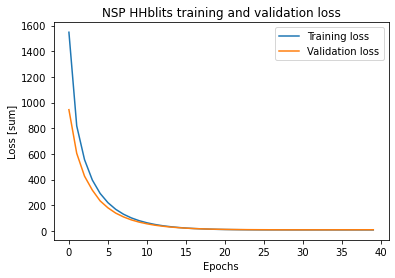

Epoch: 1  of  40
Training loss:  1566.53
Validation loss:  956.95
Epoch: 2  of  40
Training loss:  828.87
Validation loss:  611.76
Epoch: 3  of  40
Training loss:  557.76
Validation loss:  426.97
Epoch: 4  of  40
Training loss:  396.62
Validation loss:  312.38
Epoch: 5  of  40
Training loss:  292.95
Validation loss:  235.69
Epoch: 6  of  40
Training loss:  219.83
Validation loss:  179.31
Epoch: 7  of  40
Training loss:  167.92
Validation loss:  140.61
Epoch: 8  of  40
Training loss:  129.96
Validation loss:  108.35
Epoch: 9  of  40
Training loss:  101.08
Validation loss:  85.91
Epoch: 10  of  40
Training loss:  79.29
Validation loss:  68.25
Epoch: 11  of  40
Training loss:  62.73
Validation loss:  55.34
Epoch: 12  of  40
Training loss:  50.08
Validation loss:  44.29
Epoch: 13  of  40
Training loss:  40.01
Validation loss:  36.15
Epoch: 14  of  40
Training loss:  32.36
Validation loss:  29.58
Epoch: 15  of  40
Training loss:  26.41
Validation loss:  24.7
Epoch: 16  of  40
Training loss:

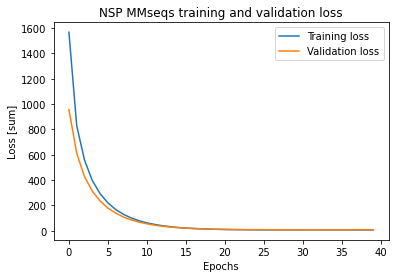

In [14]:
epochs = 40 #50

training_loss, evaluation_loss = training(epochs, nsp_hhblits[0], nsp_hhblits[1], nsp_hhblits[2], train_hhblits)
plot_loss(training_loss, evaluation_loss, "NSP HHblits training and validation loss")

training_loss, evaluation_loss = training(epochs, nsp_mmseqs[0], nsp_mmseqs[1], nsp_mmseqs[2], train_mmseqs)
plot_loss(training_loss, evaluation_loss, "NSP MMseqs training and validation loss")

## 5. Evaluation

Evaluation functions are created to evaluate the models performance.

In [15]:
def fpr(pred, labels):
    """ False positive rate
    Args:
        inputs (1D Tensor): vector with predicted binary numeric values
        labels (1D Tensor): vector with correct binary numeric values
    """
    fp = sum((pred == 1) & (labels == 0))
    tn = sum((pred == 0) & (labels == 0))
    
    return (fp/(fp+tn)).item()

def fnr(pred, labels):
    """ False negative rate
    Args:
        inputs (1D Tensor): vector with predicted binary numeric values
        labels (1D Tensor): vector with correct binary numeric values
    """
    fn = sum((pred == 0) & (labels == 1))
    tp = sum((pred == 1) & (labels == 1))
    
    return (fn/(fn+tp)).item()

def mcc(pred, labels):
    """ Mathews correlation coefficient
    Args:
        inputs (1D Tensor): vector with predicted binary numeric values
        labels (1D Tensor): vector with correct binary numeric values
    """
    fp = sum((pred == 1) & (labels == 0))
    tp = sum((pred == 1) & (labels == 1))
    fn = sum((pred == 0) & (labels == 1))
    tn = sum((pred == 0) & (labels == 0))
    
    return ((tp*tn-fp*fn)/torch.sqrt(((tp+fp)*(fn+tn)*(tp+fn)*(fp+tn)).float())).item()

def pcc(pred, labels):
    """ Pearson correlation coefficient
    Args:
        inputs (1D Tensor): vector with predicted numeric values
        labels (1D Tensor): vector with correct numeric values
    """
    x = pred - torch.mean(pred)
    y = labels - torch.mean(labels)
    
    return (torch.sum(x * y) / (torch.sqrt(torch.sum(x ** 2)) * torch.sqrt(torch.sum(y ** 2)))).item()

def mae(pred, labels):
    """ Mean absolute error
    Args:
        inputs (1D Tensor): vector with predicted numeric values
        labels (1D Tensor): vector with correct numeric values
    """
    
    return (sum(torch.min(torch.cat((abs(labels-pred).unsqueeze(1), abs(360-labels+pred).unsqueeze(1)), dim=1), dim=1)[0])/len(labels)).item()
    
def accuracy(pred, labels):
    """ Accuracy coefficient
    Args:
        inputs (1D Tensor): vector with predicted integer values
        labels (1D Tensor): vector with correct integer values
    """
    
    return (sum((pred == labels)) / len(labels)).item()

Seperate datasets are used to evaluate the model. Here is each class evaluated and the prediction benchmarks for the trained model are found.

In [16]:
def evaluation(model, dataset):
    # store evaluation results
    results = {
        "SS8": 0,
        "SS3": 0,
        "disorder_mcc": 0,
        "disorder_fnr": 0,
        "RSA": 0,
        "ASA": 0,
        "psi": 0,
        "phi": 0,
    }
    # iterate through the evaluation dataset
    with torch.no_grad():
        for data in dataset:
            # move data tensors to GPU if possible
            inputs, labels = data
            inputs, labels = inputs.to(device=device), labels.to(device=device)

            predictions = model(inputs) # predict values

            # Use only sequences from seq mask and remove extrapolated zeroes
            predictions = [pred[labels[:, :, 0] == 1] for pred in predictions]
            labels = labels[labels[:, :, 0] == 1]

            # calculate the SS8 accuracy
            SS8_labels = torch.argmax(labels[:, 7:15], dim=1).flatten()
            SS8_pred = torch.argmax(predictions[0], dim=1).flatten()

            results["SS8"] += accuracy(SS8_pred, SS8_labels)

            # calculate the SS3 accuracy
            SS3_mask = torch.tensor([0,0,0,1,1,2,2,2], device=device)

            SS3_labels = torch.max(labels[:, 7:15] * SS3_mask, dim=1)[0].long().flatten()
            SS3_pred = torch.argmax(predictions[1], dim=1).flatten()

            results["SS3"] += accuracy(SS3_pred, SS3_labels)

            # calculate the FPR of disorder
            disorder_labels = labels[:, 1].flatten()
            disorder_pred = torch.argmax(predictions[2], dim=1).flatten()

            results["disorder_mcc"] += mcc(disorder_pred, disorder_labels)
            results["disorder_fnr"] += fnr(disorder_pred, disorder_labels)

            # calculate the RSA
            rsa_labels = labels[:, 6].flatten()
            rsa_pred = predictions[3].flatten()

            results['RSA'] += pcc(rsa_pred, rsa_labels)

            # calculate the ASA
            asa_labels = labels[:, 4].flatten()
            asa_max = labels[:, 17].flatten()

            results['ASA'] += pcc(asa_max * rsa_pred, asa_labels)

            # calculate the psi
            phi_labels = labels[:, 15].flatten()
            phi_pred = arctan_dihedral(predictions[4][:, 0], predictions[4][:, 1]).flatten()

            results['phi'] += mae(phi_pred, phi_labels)

            # calculate the psi
            psi_labels = labels[:, 16].flatten()
            psi_pred = arctan_dihedral(predictions[5][:, 0], predictions[5][:, 1]).flatten()

            results['psi'] += mae(psi_pred, psi_labels)

        # average prediction results 
        for method, _ in results.items():
            results[method] /= len(dataset)

    print("RSA (PCC): {}".format(round(results["RSA"], 2)))
    print("ASA (PCC): {}".format(round(results["ASA"], 2)))
    print("SS8 [Q8]: {}".format(round(results["SS8"], 2)))
    print("SS3 [Q3]: {}".format(round(results["SS3"], 2)))
    print("Disorder (MCC): {}".format(round(results["disorder_mcc"], 2)))
    print("Disorder (FNR): {}".format(round(results["disorder_fnr"], 3)))
    print("Phi (MAE): {}".format(round(results["phi"], 2)))
    print("Psi (MAE): {}".format(round(results["psi"], 2)))

The models are evaluated

In [17]:
print("Evaluation HHblits...")

print("\nCB513")
evaluation(nsp_hhblits[0], CB513_hhblits)
print("\nTS115")
evaluation(nsp_hhblits[0], TS115_hhblits)
print("\nCASP12")
evaluation(nsp_hhblits[0], CASP12_hhblits)

print("\nEvaluation MMseqs...")

print("\nCB513")
evaluation(nsp_mmseqs[0], CB513_hhblits)
print("\nTS115")
evaluation(nsp_mmseqs[0], TS115_hhblits)
print("\nCASP12")
evaluation(nsp_mmseqs[0], CASP12_hhblits)

Evaluation HHblits...

CB513
RSA (PCC): 0.7
ASA (PCC): 0.72
SS8 [Q8]: 0.68
SS3 [Q3]: 0.82
Disorder (MCC): nan
Disorder (FNR): 0.012
Phi (MAE): 23.56
Psi (MAE): 37.44

TS115
RSA (PCC): 0.66
ASA (PCC): 0.69
SS8 [Q8]: 0.71
SS3 [Q3]: 0.82
Disorder (MCC): 0.57
Disorder (FNR): 0.019
Phi (MAE): 21.4
Psi (MAE): 33.39

CASP12
RSA (PCC): 0.59
ASA (PCC): 0.6
SS8 [Q8]: 0.67
SS3 [Q3]: 0.8
Disorder (MCC): 0.65
Disorder (FNR): 0.027
Phi (MAE): 25.38
Psi (MAE): 37.74

Evaluation MMseqs...

CB513
RSA (PCC): 0.54
ASA (PCC): 0.57
SS8 [Q8]: 0.54
SS3 [Q3]: 0.65
Disorder (MCC): nan
Disorder (FNR): 0.012
Phi (MAE): 28.16
Psi (MAE): 48.56

TS115
RSA (PCC): 0.51
ASA (PCC): 0.56
SS8 [Q8]: 0.59
SS3 [Q3]: 0.69
Disorder (MCC): 0.51
Disorder (FNR): 0.012
Phi (MAE): 25.11
Psi (MAE): 42.34

CASP12
RSA (PCC): 0.46
ASA (PCC): 0.48
SS8 [Q8]: 0.57
SS3 [Q3]: 0.68
Disorder (MCC): 0.4
Disorder (FNR): 0.021
Phi (MAE): 28.85
Psi (MAE): 44.67
